## Gear shifts on track

Plot which gear is being used at which point of the track

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colormaps
from matplotlib.collections import LineCollection
from typing import List, Dict, Any
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import fastf1

from tools.create_season_heatmap import create_season_heatmap

In [ ]:
session = fastf1.get_session(2025, 'Monza', 'Q')
session.load()

In [ ]:
lap = session.laps.pick_fastest()
tel = lap.get_telemetry()

In [ ]:
x = np.array(tel['X'].values)
y = np.array(tel['Y'].values)

points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
gear = tel['nGear'].to_numpy().astype(float)

In [ ]:
cmap = colormaps['Paired']
lc_comp = LineCollection(segments, norm=plt.Normalize(1, cmap.N+1), cmap=cmap)
lc_comp.set_array(gear)
lc_comp.set_linewidth(4)

In [ ]:
plt.gca().add_collection(lc_comp)
plt.axis('equal')
plt.tick_params(labelleft=False, left=False, labelbottom=False, bottom=False)

title = plt.suptitle(
    f"Fastest Lap Gear Shift Visualization\n"
    f"{lap['Driver']} - {session.event['EventName']} {session.event.year}"
)

cbar = plt.colorbar(mappable=lc_comp, label="Gear",
                    boundaries=np.arange(1, 10))
cbar.set_ticks(np.arange(1.5, 9.5))
cbar.set_ticklabels(np.arange(1, 9))


plt.show()

## Overlaying speed traces of two laps

Compare two fastest laps by overlaying their speed traces.

In [ ]:
import matplotlib.pyplot as plt

import fastf1.plotting

fastf1.plotting.setup_mpl(mpl_timedelta_support=True, color_scheme='fastf1')

# load a session and its telemetry data
session = fastf1.get_session(2025, 'Monaco', 'R')
session.load()

In [ ]:
ver_lap = session.laps.pick_drivers('VER').pick_fastest()
ham_lap = session.laps.pick_drivers('HAM').pick_fastest()

In [ ]:
ver_tel = ver_lap.get_car_data().add_distance()
ham_tel = ham_lap.get_car_data().add_distance()

In [ ]:
rbr_color = fastf1.plotting.get_team_color(ver_lap['Team'], session=session)
mer_color = fastf1.plotting.get_team_color(ham_lap['Team'], session=session)

fig, ax = plt.subplots()
ax.plot(ver_tel['Distance'], ver_tel['Speed'], color=rbr_color, label='VER')
ax.plot(ham_tel['Distance'], ham_tel['Speed'], color=mer_color, label='HAM')

ax.set_xlabel('Distance in m')
ax.set_ylabel('Speed in km/h')

ax.legend()
plt.suptitle(f"Fastest Lap Comparison \n "
             f"{session.event['EventName']} {session.event.year} Qualifying")

plt.show()

## Team Pace Comparison

Rank team’s race pace from the fastest to the slowest.

In [ ]:
import seaborn as sns
from matplotlib import pyplot as plt

import fastf1
import fastf1.plotting


# Load FastF1's dark color scheme
fastf1.plotting.setup_mpl(mpl_timedelta_support=False, color_scheme='fastf1')

In [ ]:
race = fastf1.get_session(2025, 'Monza', 'R')
race.load()
laps = race.laps.pick_quicklaps()

In [ ]:
transformed_laps = laps.copy()
transformed_laps.loc[:, "LapTime (s)"] = laps["LapTime"].dt.total_seconds()

# order the team from the fastest (lowest median lap time) tp slower
team_order = (
    transformed_laps[["Team", "LapTime (s)"]]
    .groupby("Team")
    .median()["LapTime (s)"]
    .sort_values()
    .index
)
print(team_order)

# make a color palette associating team names to hex codes
team_palette = {team: fastf1.plotting.get_team_color(team, session=race)
                for team in team_order}

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.boxplot(
    data=transformed_laps,
    x="Team",
    y="LapTime (s)",
    hue="Team",
    order=team_order,
    palette=team_palette,
    whiskerprops=dict(color="white"),
    boxprops=dict(edgecolor="white"),
    medianprops=dict(color="grey"),
    capprops=dict(color="white"),
)

plt.title("2025 Italian Grand Prix (Monza)")
plt.grid(visible=False)

# x-label is redundant
ax.set(xlabel=None)
plt.tight_layout()
plt.show()

Draw a track map with numbered corners
Use the position data of a single lap to draw a track map. Then annotate the map with corner numbers.

## Draw a track map with numbered corners

Use the position data of a single lap to draw a track map. Then annotate the map with corner numbers.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import fastf1


session = fastf1.get_session(2023, 'Silverstone', 'Q')
session.load()

lap = session.laps.pick_fastest()
pos = lap.get_pos_data()

circuit_info = session.get_circuit_info()

def rotate(xy, *, angle):
    rot_mat = np.array([[np.cos(angle), np.sin(angle)],
                        [-np.sin(angle), np.cos(angle)]])
    return np.matmul(xy, rot_mat)

In [ ]:
# Get an array of shape [n, 2] where n is the number of points and the second
# axis is x and y.
track = pos.loc[:, ('X', 'Y')].to_numpy()

# Convert the rotation angle from degrees to radian.
track_angle = circuit_info.rotation / 180 * np.pi

# Rotate and plot the track map.
rotated_track = rotate(track, angle=track_angle)
plt.plot(rotated_track[:, 0], rotated_track[:, 1])

offset_vector = [500, 0]  # offset length is chosen arbitrarily to 'look good'

# Iterate over all corners.
for _, corner in circuit_info.corners.iterrows():
    # Create a string from corner number and letter
    txt = f"{corner['Number']}{corner['Letter']}"

    # Convert the angle from degrees to radian.
    offset_angle = corner['Angle'] / 180 * np.pi

    # Rotate the offset vector so that it points sideways from the track.
    offset_x, offset_y = rotate(offset_vector, angle=offset_angle)

    # Add the offset to the position of the corner
    text_x = corner['X'] + offset_x
    text_y = corner['Y'] + offset_y

    # Rotate the text position equivalently to the rest of the track map
    text_x, text_y = rotate([text_x, text_y], angle=track_angle)

    # Rotate the center of the corner equivalently to the rest of the track map
    track_x, track_y = rotate([corner['X'], corner['Y']], angle=track_angle)

    # Draw a circle next to the track.
    plt.scatter(text_x, text_y, color='grey', s=140)

    # Draw a line from the track to this circle.
    plt.plot([track_x, text_x], [track_y, text_y], color='grey')

    # Finally, print the corner number inside the circle.
    plt.text(text_x, text_y, txt,
             va='center_baseline', ha='center', size='small', color='white')
    
plt.title(session.event['Location'])
plt.xticks([])
plt.yticks([])
plt.axis('equal')
plt.show()


## Driver specific plot styling
Create some plots and show the usage of `fastf1.plotting.get_driver_style`.

In [ ]:
from matplotlib import pyplot as plt

import fastf1
from fastf1 import plotting

fastf1.plotting.setup_mpl(mpl_timedelta_support=True, color_scheme='fastf1')

In [ ]:
race = fastf1.get_session(2024, "Azerbaijan", 'R')
race.load()

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))

for driver in ('HAM', 'PER', 'VER', 'RUS'):
    laps = race.laps.pick_drivers(driver).pick_quicklaps().reset_index()
    style = plotting.get_driver_style(identifier=driver,
                                      style=['color', 'linestyle'],
                                      session=race)
    ax.plot(laps['LapTime'], **style, label=driver)

ax.set_xlabel("Lap Number")
ax.set_ylabel("Lap Time")
ax.legend()

## Position changes during a race
Plot the position of each driver at the end of each lap.

In [ ]:
import matplotlib.pyplot as plt
import fastf1.plotting

fastf1.plotting.setup_mpl(mpl_timedelta_support=False, color_scheme='fastf1')

In [ ]:
session = fastf1.get_session(2023, 1, 'R')
session.load(telemetry=False, weather=False)

fig, ax = plt.subplots(figsize=(8.0, 4.9))

for drv in session.drivers:
    drv_laps = session.laps.pick_drivers(drv)

    abb = drv_laps['Driver'].iloc[0]
    style = fastf1.plotting.get_driver_style(identifier=abb,
                                             style=['color', 'linestyle'],
                                             session=session)

    ax.plot(drv_laps['LapNumber'], drv_laps['Position'],
            label=abb, **style)

ax.set_ylim([20.5, 0.5])
ax.set_yticks([1, 5, 10, 15, 20])
ax.set_xlabel('Lap')
ax.set_ylabel('Position')
ax.legend(bbox_to_anchor=(1.0, 1.02))
plt.tight_layout()

plt.show()

## Driver Laptimes Scatterplot

Plot a driver’s lap times in a race, with color coding for the compounds.

In [ ]:
import seaborn as sns
from matplotlib import pyplot as plt
import fastf1
import fastf1.plotting

fastf1.plotting.setup_mpl(mpl_timedelta_support=True, color_scheme='fastf1')

In [ ]:
race = fastf1.get_session(2025, "Monaco", 'R')
race.load()

In [ ]:
driver_laps = race.laps.pick_drivers("HAM").pick_quicklaps().reset_index()

fig, ax = plt.subplots(figsize=(8, 8))

sns.scatterplot(data=driver_laps,
                x="LapNumber",
                y="LapTime",
                ax=ax,
                hue="Compound",
                palette=fastf1.plotting.get_compound_mapping(session=race),
                s=80,
                linewidth=0,
                legend='auto')

ax.set_xlabel("Lap Number")
ax.set_ylabel("Lap Time")

# The y-axis increases from bottom to top by default
# Since we are plotting time, it makes sense to invert the axis
ax.invert_yaxis()
plt.suptitle("Hamilton Laptimes in the 2025 Monaco Grand Prix")

plt.grid(color='w', which='major', axis='both')
sns.despine(left=True, bottom=True)

plt.tight_layout()
plt.show()

## Qualifying results overview
Plot the qualifying result with visualization the fastest times.

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from timple.timedelta import strftimedelta
import fastf1
import fastf1.plotting
from fastf1.core import Laps

fastf1.plotting.setup_mpl(mpl_timedelta_support=True, color_scheme=None)


session = fastf1.get_session(2021, 'Spanish Grand Prix', 'Q')
session.load()

In [ ]:
drivers = pd.unique(session.laps['Driver'])
print(drivers)

In [ ]:
list_fastest_laps = list()
for drv in drivers:
    drvs_fastest_lap = session.laps.pick_drivers(drv).pick_fastest()
    list_fastest_laps.append(drvs_fastest_lap)
fastest_laps = Laps(list_fastest_laps) \
    .sort_values(by='LapTime') \
    .reset_index(drop=True)

pole_lap = fastest_laps.pick_fastest()
fastest_laps['LapTimeDelta'] = fastest_laps['LapTime'] - pole_lap['LapTime']

team_colors = list()
for index, lap in fastest_laps.iterlaps():
    color = fastf1.plotting.get_team_color(lap['Team'], session=session)
    team_colors.append(color)

In [ ]:
fig, ax = plt.subplots()
ax.barh(fastest_laps.index, fastest_laps['LapTimeDelta'],
        color=team_colors, edgecolor='grey')
ax.set_yticks(fastest_laps.index)
ax.set_yticklabels(fastest_laps['Driver'])

ax.invert_yaxis()

ax.set_axisbelow(True)
ax.xaxis.grid(True, which='major', linestyle='--', color='black', zorder=-1000)
lap_time_string = strftimedelta(pole_lap['LapTime'], '%m:%s.%ms')

plt.suptitle(f"{session.event['EventName']} {session.event.year} Qualifying\n"
             f"Fastest Lap: {lap_time_string} ({pole_lap['Driver']})")

plt.show()

## Who can still win the drivers WDC?
Calculates which drivers still has chance to win the WDC. Simplified since it doesn’t compare positions if points are equal.

In [ ]:
import fastf1
from fastf1.ergast import Ergast

SEASON = 2025 # for this example, we're looking at the 2025 season. 
ROUND = 16 # We want to know who can theoretically still win the drivers’ championship after the first 16 races.

In [ ]:
def get_drivers_standings():
    '''
        Get the current driver standings from Ergast. [Reference](https://docs.fastf1.dev/ergast.html#fastf1.ergast.Ergast.get_driver_standings)
    '''
    ergast = Ergast()
    standings = ergast.get_driver_standings(season=SEASON, round=ROUND)
    return standings.content[0]

def calculate_max_points_for_remaining_season():
    '''
        F1 Scoring system can be found [here](https://en.wikipedia.org/wiki/List_of_Formula_One_World_Championship_points_scoring_systems).
    '''
    POINTS_FOR_SPRINT = 8 + 25 # Winning the sprint and race
    POINTS_FOR_CONVENTIONAL = 25 # Winning the race

    events = fastf1.events.get_event_schedule(SEASON, backend='ergast')
    events = events[events['RoundNumber'] > ROUND]
    # Count how many sprints and conventional races are left
    sprint_events = len(events.loc[events["EventFormat"] == "sprint_shootout"])
    conventional_events = len(events.loc[events["EventFormat"] == "conventional"])

    # Calculate points for each
    sprint_points = sprint_events * POINTS_FOR_SPRINT
    conventional_points = conventional_events * POINTS_FOR_CONVENTIONAL

    return sprint_points + conventional_points

def calculate_who_can_win(driver_standings, max_points):
    '''
        For each driver we will see if there is a chance to get more points than the current leader. 
        We assume the leader gets no more points and the driver gets the theoretical maximum amount of points.
        We currently don’t consider the case of two drivers getting equal points since its more complicated and would require comparing positions.
    '''
    LEADER_POINTS = int(driver_standings.loc[0]['points'])

    for i, _ in enumerate(driver_standings.iterrows()):
        driver = driver_standings.loc[i]
        driver_max_points = int(driver["points"]) + max_points
        can_win = 'No' if driver_max_points < LEADER_POINTS else 'Yes'

        print(f"{driver['position']}: {driver['givenName'] + ' ' + driver['familyName']}, "
              f"Current points: {driver['points']}, "
              f"Theoretical max points: {driver_max_points}, "
              f"Can win: {can_win}")

In [ ]:
# Get the current drivers standings
driver_standings = get_drivers_standings()

# Get the maximum amount of points
points = calculate_max_points_for_remaining_season()

# Print which drivers can still win
calculate_who_can_win(driver_standings, points)

## Speed visualization on track map

core           INFO 	Loading data for Abu Dhabi Grand Prix - Qualifying [v3.7.0]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
req            INF

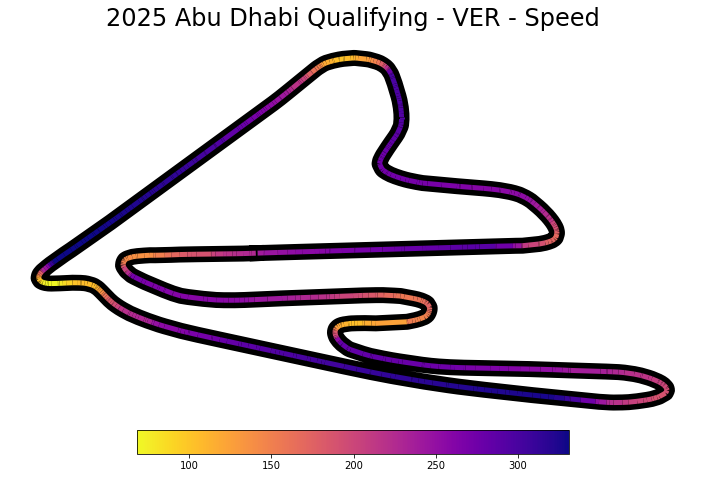

In [8]:
from tools.speed_visualization import plot_fastest_lap

plot_fastest_lap(year=2025, gp=24, ses='Q', driver='VER')

## Plot driver standings in a heatmap
Plot the points for each driven in each race of a given season in a heatmap, [see](https://docs.fastf1.dev/gen_modules/examples_gallery/plot_results_tracker.html)

In [ ]:
import pandas as pd
import plotly.express as px
from plotly.io import show

from fastf1.ergast import Ergast

In [ ]:
ergast = Ergast()
races = ergast.get_race_schedule(2024)
results = []

for rnd, race in races['raceName'].items():

    # Get results. Note that we use the round no. + 1, because the round no.
    temp = ergast.get_race_results(season=2024, round=rnd + 1) # starts from one (1) instead of zero (0)
    temp = temp.content[0]

    # If there is a sprint, get the results as well
    sprint = ergast.get_sprint_results(season=2024, round=rnd + 1)
    if sprint.content and sprint.description['round'][0] == rnd + 1:
        temp = pd.merge(temp, sprint.content[0], on='driverCode', how='left')
        # Add sprint points and race points to get the total
        temp['points'] = temp['points_x'] + temp['points_y']
        temp.drop(columns=['points_x', 'points_y'], inplace=True)

    # Add round no. and grand prix name
    temp['round'] = rnd + 1
    temp['race'] = race.removesuffix(' Grand Prix')
    temp = temp[['round', 'race', 'driverCode', 'points']]  # Keep useful cols.
    results.append(temp)

results = pd.concat(results)
races = results['race'].drop_duplicates()

In [ ]:
results = results.pivot(index='driverCode', columns='round', values='points')

results['total_points'] = results.sum(axis=1)
results = results.sort_values(by='total_points', ascending=False)
results.drop(columns='total_points', inplace=True)

results.columns = races

In [ ]:
fig = px.imshow(
    results,
    text_auto=True,
    aspect='auto',
    color_continuous_scale=[[0,    'rgb(198, 219, 239)'],
                            [0.25, 'rgb(107, 174, 214)'],
                            [0.5,  'rgb(33,  113, 181)'],
                            [0.75, 'rgb(8,   81,  156)'],
                            [1,    'rgb(8,   48,  107)']],
    labels={'x': 'Race',
            'y': 'Driver',
            'color': 'Points'}
)
fig.update_xaxes(title_text='')
fig.update_yaxes(title_text='')
fig.update_yaxes(tickmode='linear')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='LightGrey',
                 showline=False,
                 tickson='boundaries')              
fig.update_xaxes(showgrid=False, showline=False)    
fig.update_layout(plot_bgcolor='rgba(0,0,0,0)')    
fig.update_layout(coloraxis_showscale=False)        
fig.update_layout(xaxis=dict(side='top'))           
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig
show(fig)

## Season Summary Visualization
This example demonstrates how to make an interactive season summarization dashboard using Plotly showing points scored by each driver at each round.

In [ ]:
fig = create_season_heatmap(2025)
fig.show()